In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"]= "/content" #folder

In [ ]:
!kaggle datasets download -d prasoonkottarathil/polycystic-ovary-syndrome-pcos

  0% 0.00/120k [00:00<?, ?B/s]
100% 120k/120k [00:00<00:00, 71.5MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  polycystic-ovary-syndrome-pcos.zip
  inflating: PCOS_data_without_infertility.xlsx  
  inflating: PCOS_infertility.csv    


#Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#Importing Dataset

In [ ]:
file_path_with_infertility="/content/PCOS_infertility.csv"
file_path_without_infertility="/content/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

#Data PreProcessing
1. Merging the dataset(two files)
2. Dropping the repeated features
3. Encoding categorical variables
4. Dealing with missing data

In [ ]:
#Merging the two files as per patient file no.
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head()

<ipython-input-6-11b7d2035088>:3: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [ ]:
data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,540.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.514815,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500244,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [ ]:
#Encoding categorical variables
data["AMH(ng/mL)"].head()

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [ ]:
data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

#conclusion
1. Some numerical data are saved as strings
2. There are some missing values

#Dealing with Categorical values

In [ ]:
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values.
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

#Exploratory Data Analysis
1. Feature selection based on the correlation factor.
2. Some miscellaneous EDA

In [ ]:
#Dropping the outliers.

data = data[(data["BP _Diastolic (mmHg)"]>20)]
data = data[(data["AMH(ng/mL)"]<40)]
data = data[(data["BP _Systolic (mmHg)"]>20)]
data = data[(data["Endometrium (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["RBS(mg/dl)"]<200)]
data = data[(data["PRG(ng/mL)"]<20)]
data = data[(data["Pulse rate(bpm)"]>20)]
data = data[(data["FSH(mIU/mL)"]<4000)]
data = data[(data["LH(mIU/mL)"]<1500)]
data = data[(data["Cycle(R/I)"]<4.5)]

data.shape

(526, 44)

#Correlation Matrix

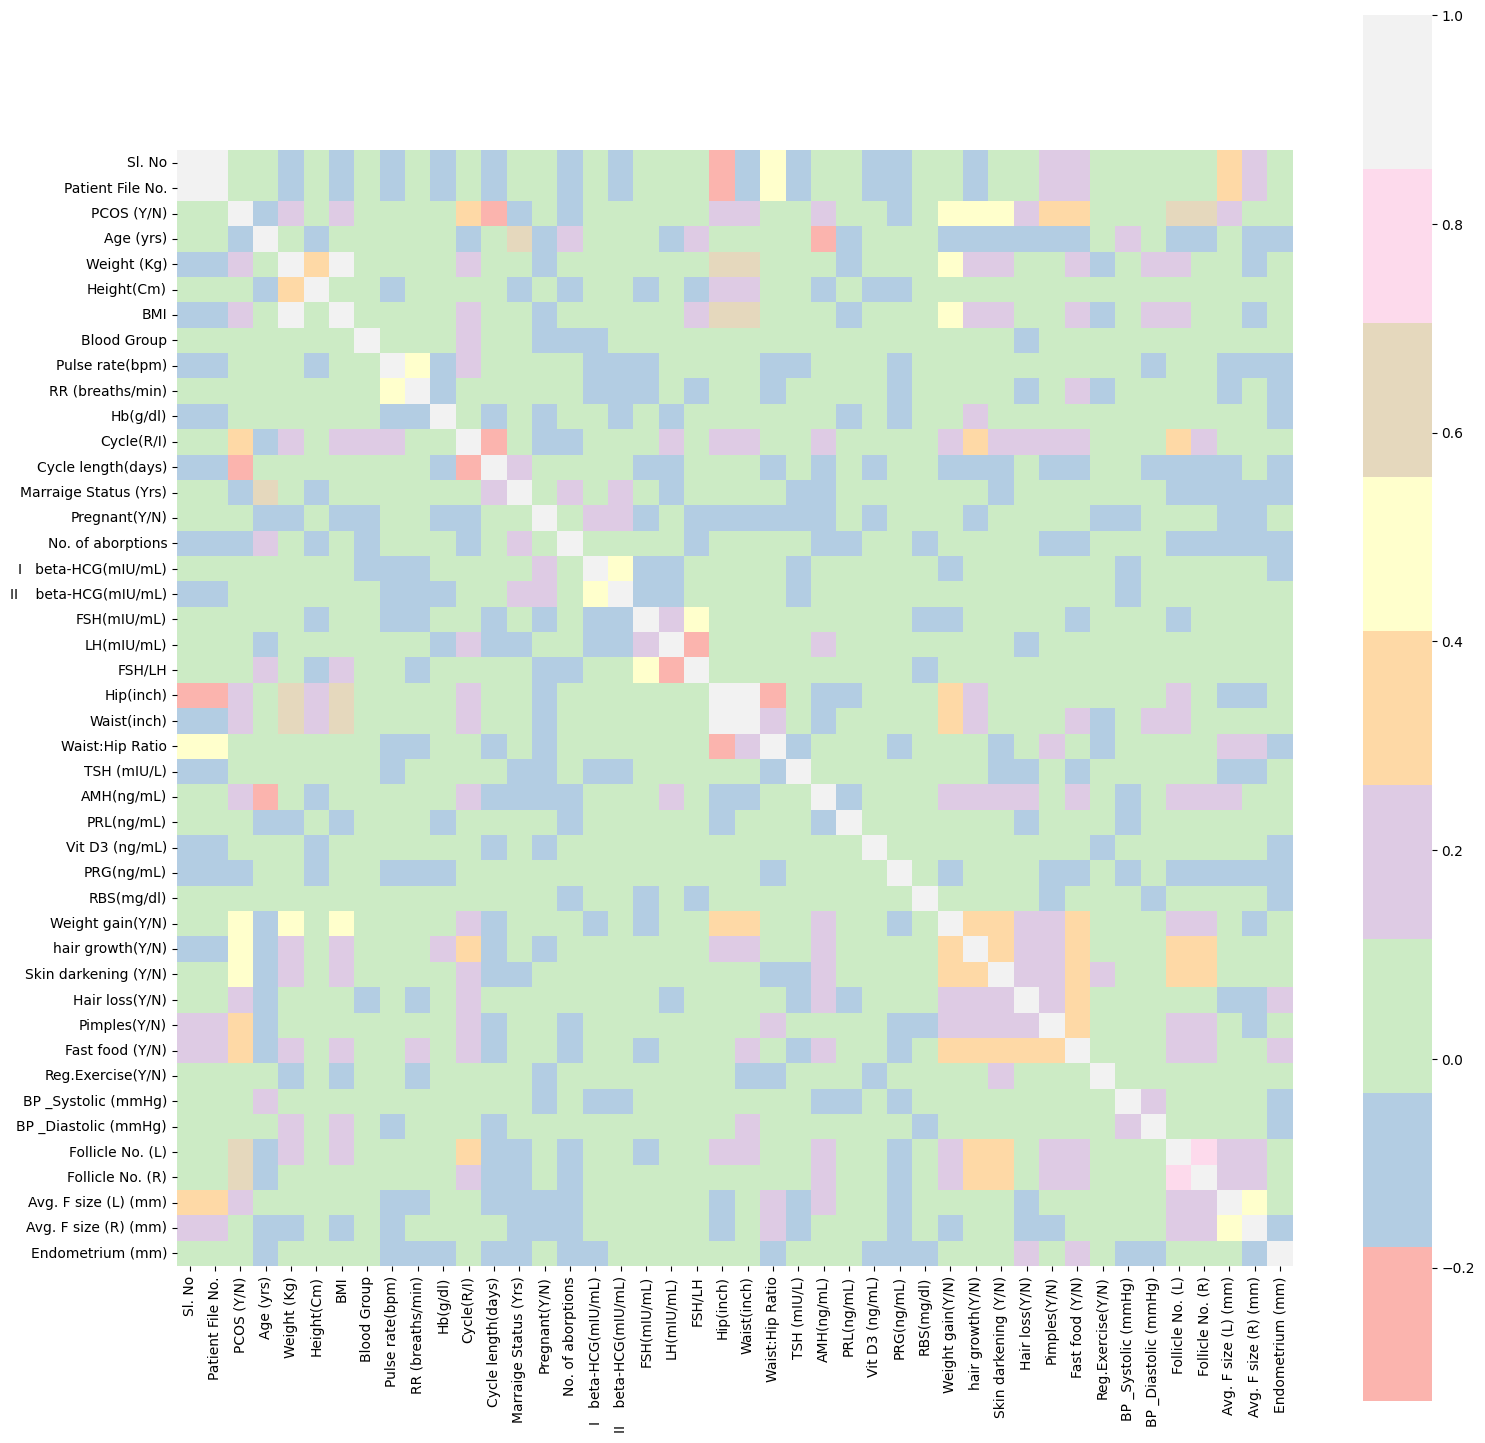

In [ ]:
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Pastel1", square=True);

In [ ]:
#How all the features correlate with the PCOS

corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650915
Follicle No. (L)          0.605305
Skin darkening (Y/N)      0.474561
hair growth(Y/N)          0.463557
Weight gain(Y/N)          0.445646
Cycle(R/I)                0.404082
Fast food (Y/N)           0.376877
Pimples(Y/N)              0.295313
AMH(ng/mL)                0.261105
Weight (Kg)               0.210241
BMI                       0.194121
Hair loss(Y/N)            0.176603
Hip(inch)                 0.163335
Waist(inch)               0.160226
Avg. F size (L) (mm)      0.124990
Pulse rate(bpm)           0.102988
LH(mIU/mL)                0.095426
Hb(g/dl)                  0.094481
Vit D3 (ng/mL)            0.086052
Endometrium (mm)          0.085608
Avg. F size (R) (mm)      0.084756
Height(Cm)                0.075431
Reg.Exercise(Y/N)         0.061816
Sl. No                    0.051936
Patient File No.          0.051936
FSH/LH                    0.043591
Blood Group               0.043032
RR (breaths/min)    

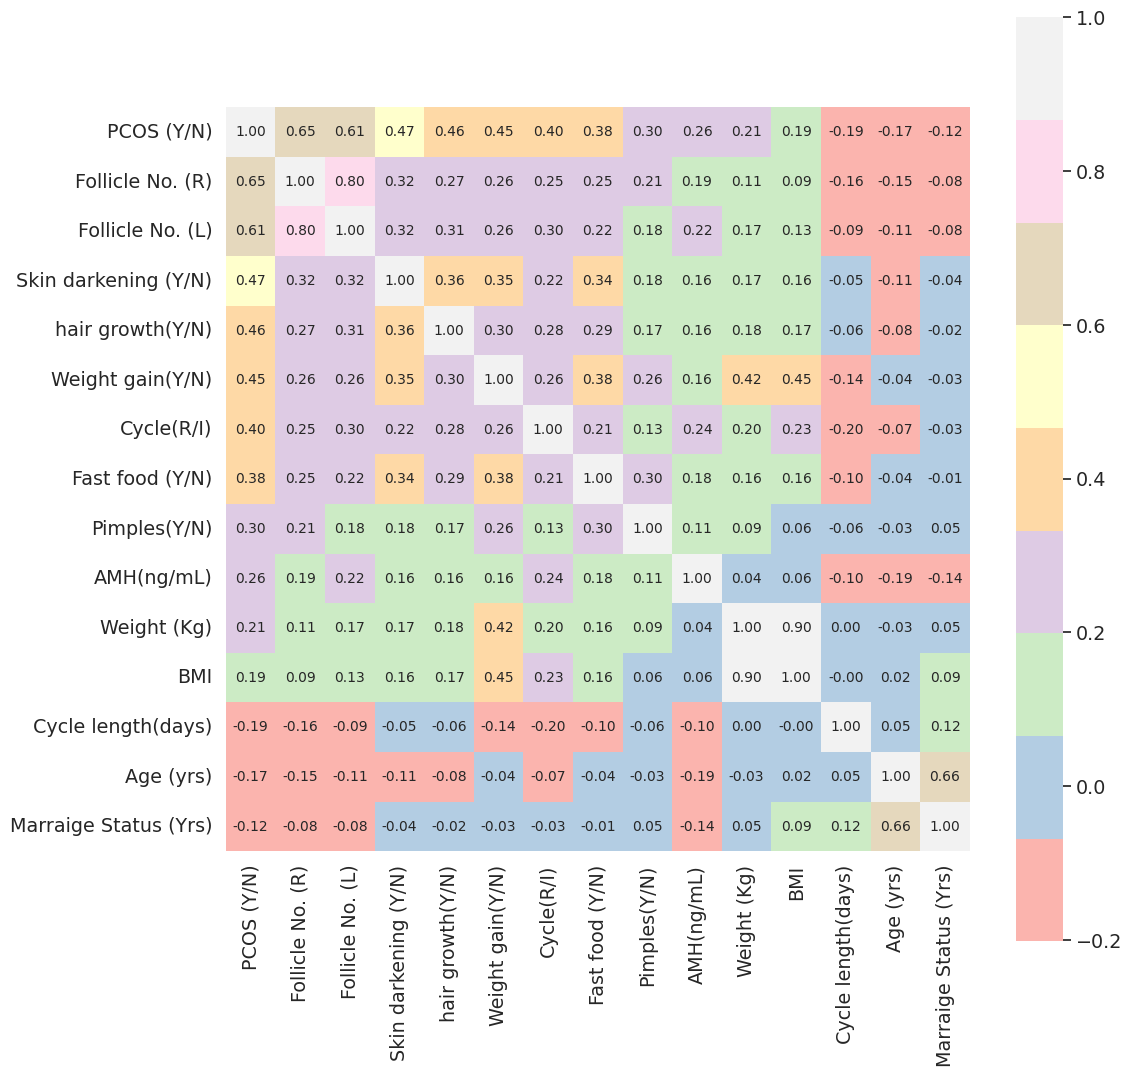

In [ ]:
plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n)

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#Pattern Length of the Menstrual Cycle

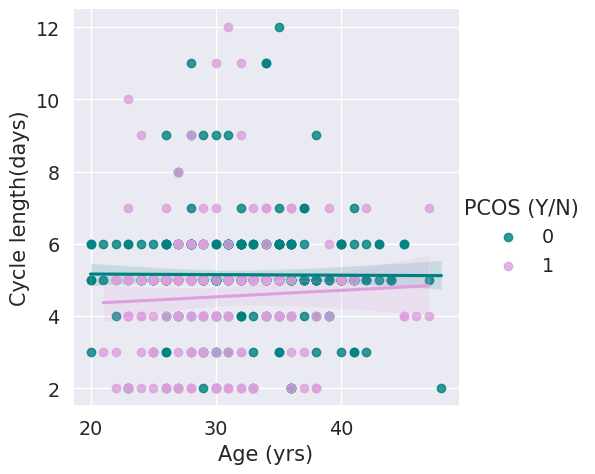

In [ ]:
# Length of menstrual phase in PCOS vs normal
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

#Pattern of BMI

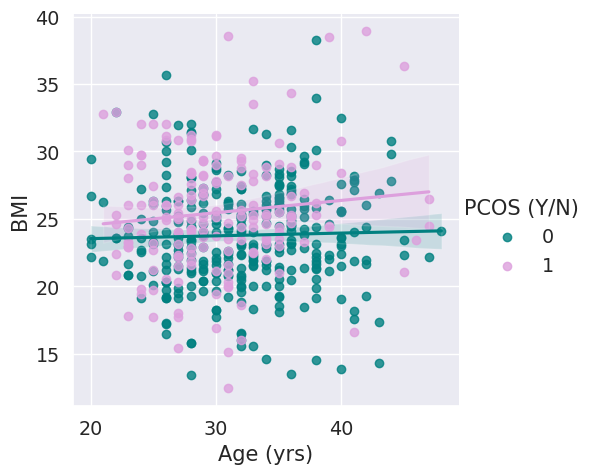

In [ ]:
# Pattern of weight gain (BMI) over years in PCOS and Normal.
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

#Patterns Of Irregularity In Mensuration

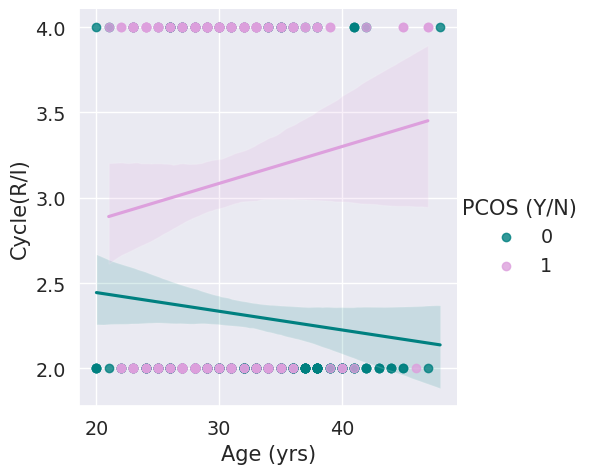

In [ ]:
# cycle IR wrt age
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

#Number Of Follicles



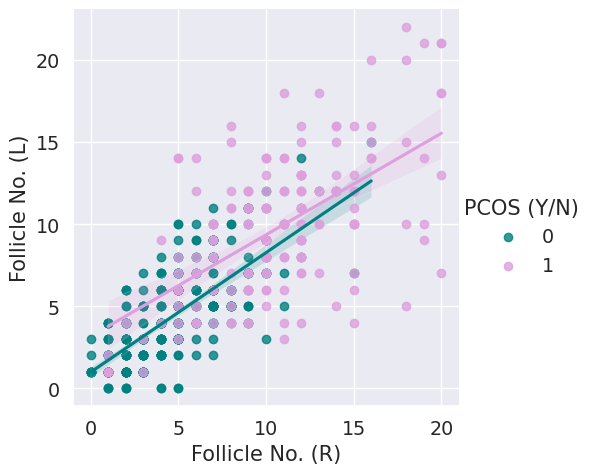

In [ ]:
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

It shows that the distribution of follicies in both ovaries Left and Right are not equal for women with PCOS

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


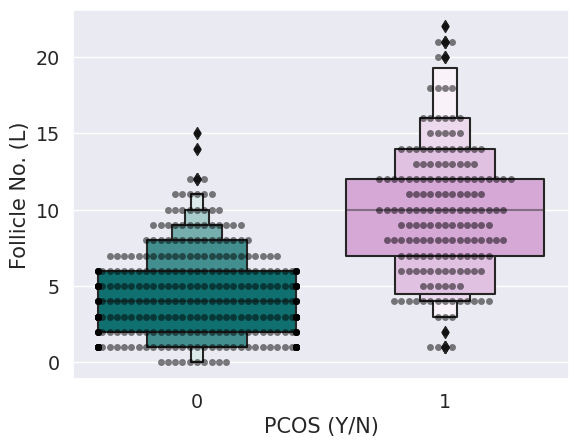

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


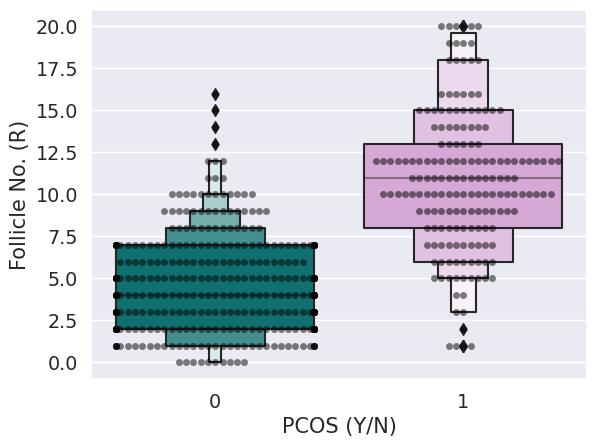

In [ ]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

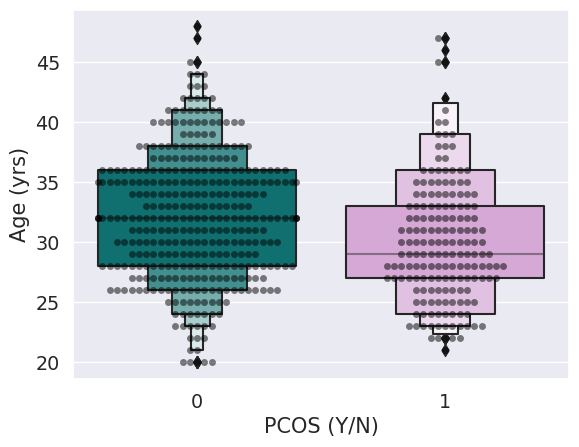

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


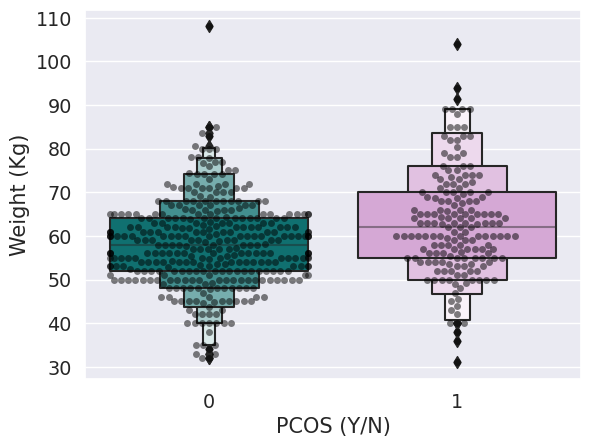

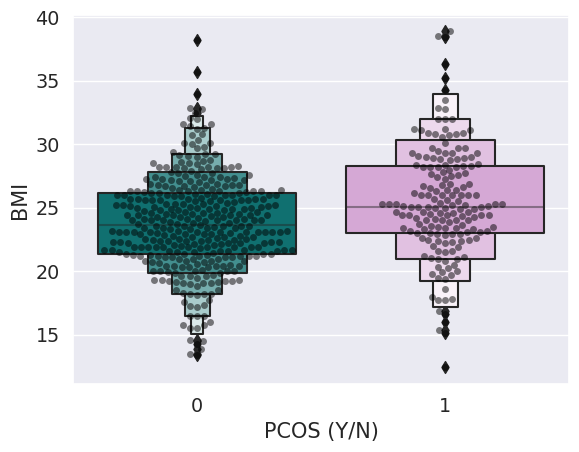

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


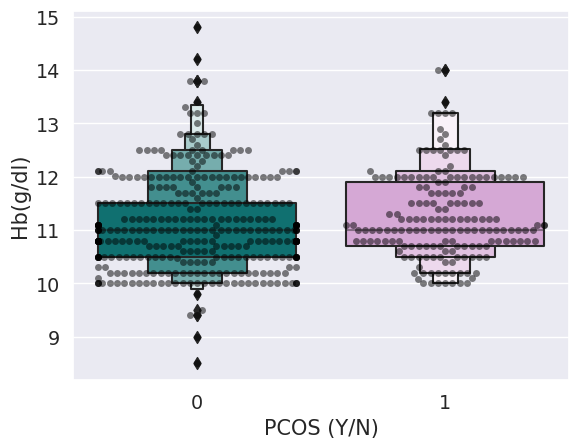

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 25.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


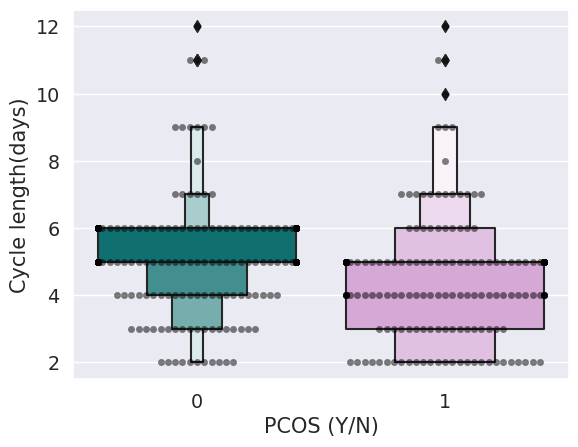

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


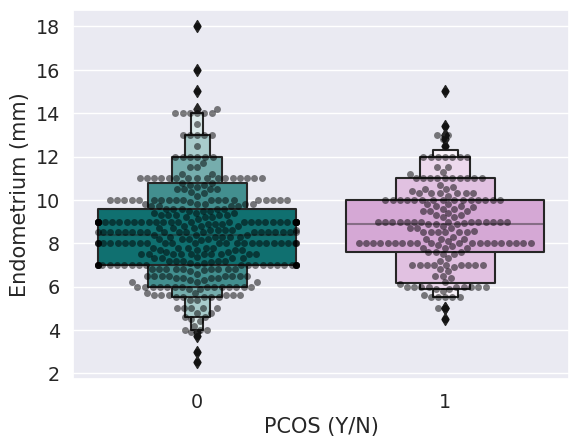

In [ ]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

#Building Model
1. Assigning values to features as X and target as y
2. Split test and training sets
3. Hyperparameter tuning using GridSearch CV
4. Fitting the final model
5. Evaluating the confusion matrix
6. Evaluating the classification report

In [ ]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

#Random Forest Classifier

In [ ]:
#Fitting the RandomForestClassifier to the training set

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.8734177215189873


In [30]:
#Building a dictionalry with list of optional values that will me analyesed by GridSearch CV

parameters = {
    'n_estimators': [100,150, 200,500,700],
    'max_features': ['log2'],
    'max_depth' : [4,5,6,7,8,9,10,12],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1,1,None]
}

#Fitting the trainingset to find parameters with best accuracy

CV_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, cv= 7)
CV_rfc.fit(X_train, y_train)

#Getting the outcome of gridsearch

CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 100,
 'n_jobs': -1}

In [31]:
#Fitting the model with selected parameters

rfc1=RandomForestClassifier(**CV_rfc.best_params_)
rfc1.fit(X_train, y_train)

#Testing the Model on test set

predictions=rfc1.predict(X_test)
acccuracy_final = accuracy_score(y_test,predictions)

acccuracy_final

0.8734177215189873

#Classification Report And Confusion Matrix

In [32]:
classi_report = classification_report(y_test, predictions)
print(classi_report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       107
           1       0.83      0.76      0.80        51

    accuracy                           0.87       158
   macro avg       0.86      0.84      0.85       158
weighted avg       0.87      0.87      0.87       158



<Axes: >

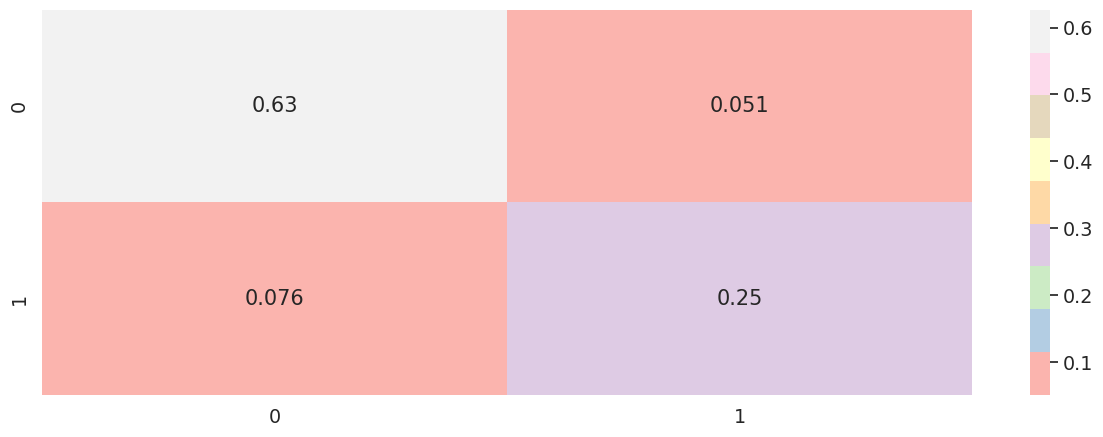

In [33]:
# cofusion matrix
plt.subplots(figsize=(15,5))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [35]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [38]:
# Print the classification report (precision, recall, F1-score, etc.)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       107
           1       0.78      0.63      0.70        51

    accuracy                           0.82       158
   macro avg       0.81      0.77      0.79       158
weighted avg       0.82      0.82      0.82       158



In [39]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[98  9]
 [19 32]]


<Axes: >

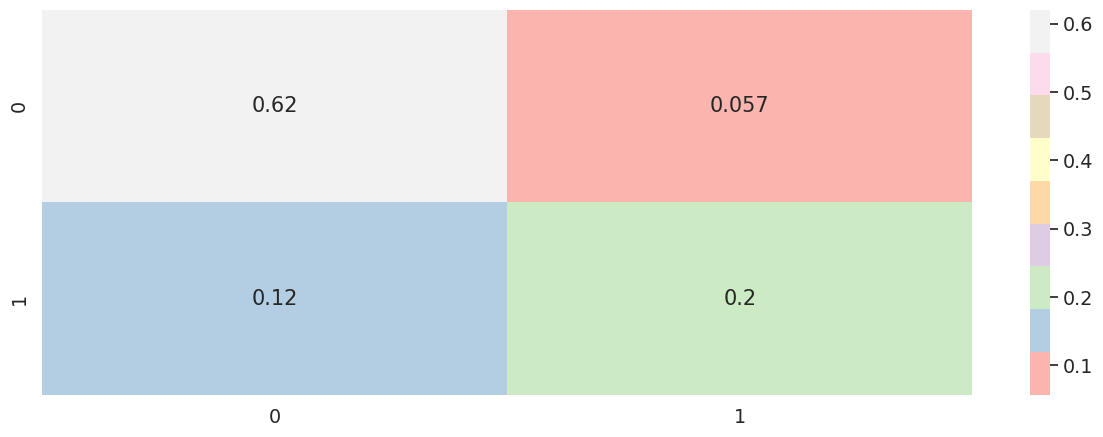

In [41]:
# cofusion matrix
plt.subplots(figsize=(15,5))
logreg = confusion_matrix(y_test, y_pred)
sns.heatmap(logreg/np.sum(logreg), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

#Support Vector Machine

In [42]:
from sklearn.svm import SVC

Kernel = Linear

In [43]:
svm_model = SVC(kernel='linear')

In [44]:
# Train the SVM model on the training data
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [45]:
# Make predictions on the test data
y_pred = svm_model.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0])

In [46]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8734177215189873


In [47]:
# Print the classification report (includes precision, recall, f1-score, and support for each class)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       107
           1       0.79      0.82      0.81        51

    accuracy                           0.87       158
   macro avg       0.85      0.86      0.86       158
weighted avg       0.87      0.87      0.87       158



In [48]:
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[96 11]
 [ 9 42]]


<Axes: >

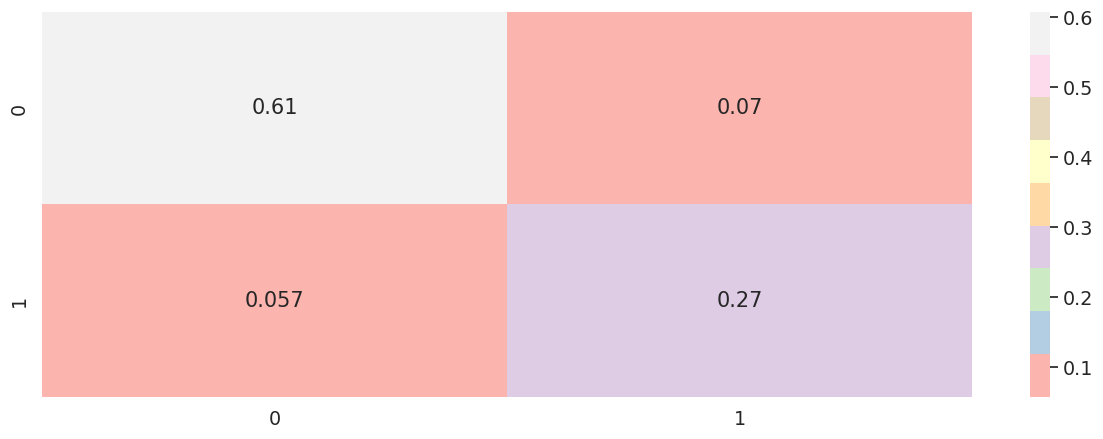

In [50]:
# cofusion matrix
plt.subplots(figsize=(15,5))
svm= confusion_matrix(y_test, y_pred)
sns.heatmap(svm/np.sum(svm), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

#GradientBoosting Classifier

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

In [52]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, random_state=1000)

In [53]:
# Train the model on the training data
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=1000)

In [54]:
# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

In [55]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0])

In [56]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 86.71%


<Axes: >

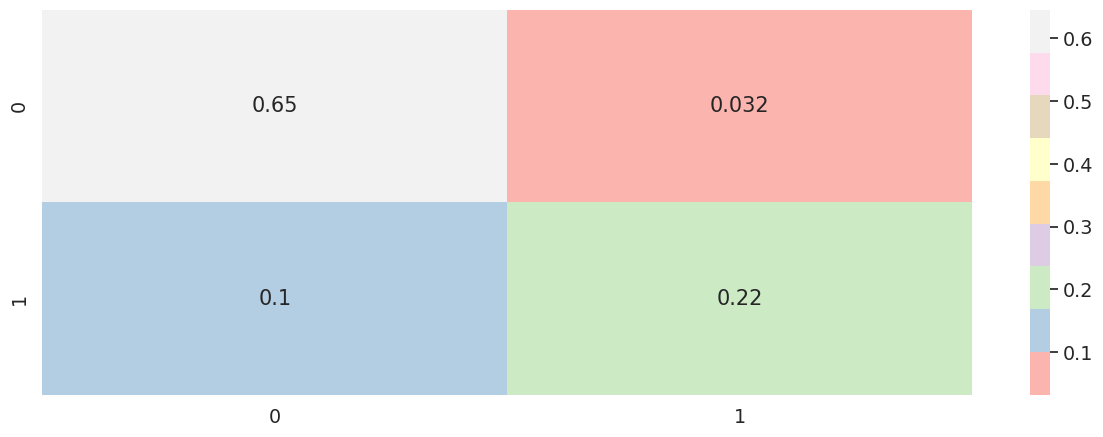

In [58]:
# cofusion matrix
plt.subplots(figsize=(15,5))
gb_classifier= confusion_matrix(y_test, y_pred)
sns.heatmap(gb_classifier/np.sum(gb_classifier), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

#Pandas Profiling

In [59]:
! pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     / 22.6 MB 22.6 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 27.6 MB/s eta 0:00:00


In [63]:
from pandas_profiling import ProfileReport

In [64]:
df = pd.read_csv("/content/PCOS_infertility.csv")

In [65]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]